In [2]:
import numpy as np
import os
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import sqlite3
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
import tensorflow as tf
from collections import Counter

In [3]:
%reload_ext autoreload
%autoreload 2

from functions_ml import refactor_video_into_input

In [8]:
IMAGE_SIZE = (256, 256)
SEQUENCE_LENGTH = 15
POSE_START_INDEX = 11
POSE_END_INDEX = 23

IMG_DIR = 'test_img'
RECORDINGS_DIR = 'recordings'
LOADED_VIDEOS_DIR = 'loaded_videos'

DB_NAME = 'slr.db'
TABLE_NAME = 'sign_videos'

DETECTOR_MODEL_NAME = 'pose_landmarker.task'

In [9]:
os.getcwd()

'c:\\Users\\Piotr.Matys\\Python_Projects\\Computer-Vision-Sign-Language\\jupyter_notebooks'

In [10]:
with open(DETECTOR_MODEL_NAME, 'rb') as det_bytes_model:
    model_data = det_bytes_model.read()

In [11]:
base_options = python.BaseOptions(model_asset_buffer=model_data)
running_mode = vision.RunningMode


detector_options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=False,
    running_mode=running_mode.VIDEO)


### Connect to db

In [12]:
conn = sqlite3.connect(os.path.join("..", DB_NAME))
cursor = conn.cursor()

In [8]:
cursor.execute('SELECT name FROM sign_videos where verified = 1')
res = cursor.fetchall()

In [33]:
videos = os.listdir(os.path.join("..", LOADED_VIDEOS_DIR)) \
    + os.listdir(os.path.join("..", RECORDINGS_DIR))

In [34]:
to_del = set(res).difference(set(videos))
to_del

{'2023_11_12_13_49_31__SLR.webm'}

In [170]:
cursor.execute(f"DELETE FROM sign_videos WHERE name = '2023_11_14_10_40_49__SLR.webm'")
conn.commit()

### Get saved videos

In [171]:
cursor.execute('SELECT name, video_array, true_label FROM sign_videos where verified = 1')
res = cursor.fetchall()

In [172]:
v_names = [r[2] for r in res]
mapping_classes = {
    "hello": 0,
    "love": 1,
    "please": 2,
    "thank you": 3,
    "what": 4,
}


In [173]:
from collections import Counter
Counter(v_names)

Counter({'what': 96, 'hello': 96, 'thank you': 96, 'please': 95, 'love': 95})

In [23]:
X, Y = [], []
all_keypoints = []

In [33]:

for video_name, _, gesture in res:

    video_path = os.path.join("..", RECORDINGS_DIR, video_name)

    if not os.path.exists(video_path):
        video_path = os.path.join("..", LOADED_VIDEOS_DIR, video_name)

    if not os.path.exists(video_path):
        print(f"Path: {video_path} does not exist")

    print(f"Processing: {video_path}")

    try:

        keypoints = refactor_video_into_input(
            video_path=video_path,
            use_visibility=False,
            pose_indexes=(POSE_START_INDEX, POSE_END_INDEX),
            video_task=True,
            detector_options=detector_options,
            sequence_length=15,
        )

    except Exception as e:

        print(f"For {video_name} error occured: {e}")

    else:

        if not isinstance(keypoints, np.ndarray):
            continue

        # reshaped = keypoints.reshape(SEQUENCE_LENGTH, -1)

        
        update_sql = """
            UPDATE sign_videos SET video_array = ? WHERE name = ? 
        """

        try:
            cursor.execute(update_sql, (keypoints.tobytes(), video_name))
        except Exception as e:
            print(f"For {video_name} error occured: {e}")
        else:
            conn.commit()

        all_keypoints.append(keypoints)
        Y.append(gesture)

    finally:
        print('\n')

Processing: ..\recordings\please_video_1.mp4
Steps: 14 - applying padding


Processing: ..\recordings\please_video_4.mp4
Steps: 14 - applying padding


Processing: ..\recordings\please_video_5.mp4


Processing: ..\recordings\please_video_6.mp4


Processing: ..\recordings\please_video_7.mp4


Processing: ..\recordings\please_video_8.mp4
Steps: 14 - applying padding


Processing: ..\recordings\please_video_9.mp4


Processing: ..\recordings\please_video_10.mp4


Processing: ..\recordings\please_video_11.mp4
Steps: 14 - applying padding


Processing: ..\recordings\please_video_12.mp4


Processing: ..\recordings\please_video_13.mp4
Steps: 14 - applying padding


Processing: ..\recordings\please_video_14.mp4


Processing: ..\recordings\please_video_16.mp4


Processing: ..\recordings\please_video_17.mp4


Processing: ..\recordings\please_video_18.mp4
Steps: 14 - applying padding


Processing: ..\recordings\please_video_19.mp4


Processing: ..\recordings\please_video_20.mp4


Processing: ..\re

### Get keypoints for rotated image

In [34]:
translation_vec = np.array([-0.5, 0, -0.5])
# translation_vec2 = np.array([-0.5, 0, 0.5])

In [174]:
arrs = [np.frombuffer(v, dtype=np.float16).shape for n, v, _ in res]
arrs

[(540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 (540,),
 

In [467]:
X = np.array([np.frombuffer(v, dtype=np.float16).reshape(SEQUENCE_LENGTH, -1, 3) for name, v, true_label in res])
Y = [label for _, _, label in res]

In [468]:
mapping_classes = {
    "hello": 0,
    "love": 1,
    "please": 2,
    "thank you": 3,
    "what": 4,
}

Y = [mapping_classes.get(y) for y in Y]

In [469]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X, 
    Y,
    train_size=0.8, 
    random_state=42, 
    stratify=Y
)

In [470]:
train_angles_x = np.arange(-10, 10, 2.5)
train_angels_y = np.arange(-35, 36, 2)
train_angles_z = np.arange(-3, 4, 2)

In [471]:
train_angles_x, train_angels_y, train_angles_z

(array([-10. ,  -7.5,  -5. ,  -2.5,   0. ,   2.5,   5. ,   7.5]),
 array([-35, -33, -31, -29, -27, -25, -23, -21, -19, -17, -15, -13, -11,
         -9,  -7,  -5,  -3,  -1,   1,   3,   5,   7,   9,  11,  13,  15,
         17,  19,  21,  23,  25,  27,  29,  31,  33,  35]),
 array([-3, -1,  1,  3]))

In [472]:
def get_rot_y(angle: int):

    theta = np.radians(angle)

    return np.array([
        [np.cos(theta), 0, -np.sin(theta)],
        [0, 1, 0],
        [np.sin(theta), 0, np.cos(theta)]
    ])

In [473]:
def get_rot_x(angle: int):

    theta = np.radians(angle)

    return np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])


In [474]:
def get_rot_z(angle: int):

    theta = np.radians(angle)

    return np.array([
        [np.cos(theta), -np.sin(theta), 0],
        [np.sin(theta), np.cos(theta), 0],
        [0, 0, 1]
    ])


In [475]:
from typing import Callable

In [476]:
np.random.seed(42)

In [478]:
def rot_aug(
    X: np.array,
    Y: np.array or list,
    rot_mat_f: Callable,
    angles: np.array,
    set_part: float = 0.5,
    translation_vec: np.array = np.array([-0.5, 0, -0.5])) -> np.array:

    Y = np.array(Y)

    X_aug = None
    Y_aug = None

    for angle in angles:

        if angle == 0:
            continue

        rotation_matrix = rot_mat_f(angle)
        random_rotate_indexes = np.random.choice(X.shape[0], int(X.shape[0] * set_part), replace=False)
        
        rotation_result = (
            (rotation_matrix @ (X[random_rotate_indexes].reshape(-1, 3) + translation_vec).T).T 
            - translation_vec
        ).reshape(len(random_rotate_indexes), SEQUENCE_LENGTH, -1, 3)

        if X_aug is None:

            X_aug = rotation_result
            Y_aug = Y[random_rotate_indexes]
            continue

        X_aug = np.concatenate((X_aug, rotation_result))
        Y_aug = np.concatenate((Y_aug, Y[random_rotate_indexes]))

    return np.concatenate((X, X_aug)), np.concatenate((Y, Y_aug))

In [480]:
X_aug, Y_aug = rot_aug(
    X=X_train, 
    Y=Y_train,
    rot_mat_f=get_rot_y, 
    angles=train_angels_y,
    set_part=0.5,
    translation_vec=translation_vec
)

In [481]:
X_aug.shape, Y_aug.shape

((7258, 15, 12, 3), (7258,))

In [482]:
X_aug, Y_aug = rot_aug(
    X=X_aug, 
    Y=Y_aug,
    rot_mat_f=get_rot_x, 
    angles=train_angles_x,
    set_part=0.3
)

In [483]:
X_aug.shape, Y_aug.shape

((22497, 15, 12, 3), (22497,))

In [484]:
X_aug, Y_aug = rot_aug(
    X=X_aug, 
    Y=Y_aug,
    rot_mat_f=get_rot_z, 
    angles=train_angles_z,
    set_part=0.2
)

In [485]:
X_aug.shape, Y_aug.shape

((40493, 15, 12, 3), (40493,))

In [486]:
swap_pattern = [i + 1 if i % 2 == 0 else i - 1 for i in range(12)]
swap_pattern

[1, 0, 3, 2, 5, 4, 7, 6, 9, 8, 11, 10]

In [487]:
indexes_swap_hands = np.random.choice(
    np.arange(X_aug.shape[0]), 
    int(0.07 * X_aug.shape[0]), 
    replace=False
)

In [488]:
X_aug[indexes_swap_hands] = X_aug[indexes_swap_hands][:, :, swap_pattern]

In [489]:
X_aug.shape

(40493, 15, 12, 3)

### Augmentation horizontal flip

In [490]:
X_aug_copy = X_aug.copy()
X_aug_copy[:, :, :, 0] = 1 - X_aug_copy[:, :, :, 0]
X_aug_copy[:, :, :, 2] = 1 - X_aug_copy[:, :, :, 2]
X_aug = np.concatenate((X_aug, X_aug_copy), axis=0)

In [491]:
del X_aug_copy

In [492]:
X_aug.shape

(80986, 15, 12, 3)

In [493]:
Y_aug = np.concatenate((Y_aug, Y_aug), axis=0)

In [494]:
indexes_gauss = np.random.choice(
    np.arange(X_aug.shape[0]), 
    int(0.3 * X_aug.shape[0]), 
    replace=False
)

In [495]:
gauss_noise = np.random.normal(0, 0.02, size=len(indexes_gauss))

In [496]:
gauss_noise = gauss_noise[:, np.newaxis, np.newaxis, np.newaxis]

In [497]:
X_aug[indexes_gauss, :, :, :] += gauss_noise

In [499]:
X_train_kp_diff = np.diff(
    a=X_aug,
    axis=1
)

In [622]:
X_val_kp_diff = np.diff(
    a=X_val,
    axis=1
)

In [501]:
X_train_kp_diff.shape, Y_aug.shape

((80986, 14, 12, 3), (80986,))

### Augmentation horizontal flip

In [502]:
X_train_kp_diff = X_train_kp_diff.reshape(X_train_kp_diff.shape[0], SEQUENCE_LENGTH - 1, -1)

In [503]:
X_train_kp_diff.shape

(80986, 14, 36)

In [504]:
Y_aug, Y_val = to_categorical(Y_aug), to_categorical(Y_val)

In [505]:
X_aug = tf.cast(X_aug, tf.float32)
Y_aug = tf.cast(Y_aug, tf.float32)

### Simple training

In [518]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, LayerNormalization

In [560]:
def create_lstm_model(input_shape, units):

    model = tf.keras.Sequential([

            Bidirectional(
                LSTM(
                    64,
                    return_sequences=False, 
                    activation='relu', 
                    input_shape=input_shape, 
                    recurrent_dropout=0.25
                )
            ),
            Dense(units=units, activation="softmax")
        ])

    return model
    

### **Set hyperparams and needed callbacks**

In [589]:
LR = 0.001
EPOCHS = 2000
ES_PATIENCE = 10
LR_REDUCE = 5
BATCH_SIZE = 128
VAL_BATCH_SIZE = 128

In [590]:
import tensorflow_addons as tfa

In [591]:
lstm_model = create_lstm_model(input_shape=(SEQUENCE_LENGTH - 1, X_train_kp_diff.shape[-1]), units=len(set(Y)))

lstm_model.compile(optimizer=tfa.optimizers.AdamW(weight_decay=0.002, learning_rate=LR, clipnorm=1.0), #choosing optimizer
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), #loss function
                    metrics=['categorical_accuracy']) 

# path_to_convlstm_model = os.path.join('models', 'lstm_more_data.ckpt')
path_to_convlstm_history = os.path.join('models', 'ROT_AUG_TRAIN_15seq.csv')

callbacks = [EarlyStopping(monitor='val_loss', patience=ES_PATIENCE, restore_best_weights=True),
             CSVLogger(path_to_convlstm_history, append=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=LR_REDUCE)]

### **Train model**

In [592]:
lstm_history = lstm_model.fit(  
    x=X_train_kp_diff,
    y=Y_aug,
    # validation_data=(X_val_kp_diff, Y_val),
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_batch_size=VAL_BATCH_SIZE,
    workers=-1,
    use_multiprocessing=True,
    callbacks = callbacks
)

Epoch 1/2000
 59/507 [==>...........................] - ETA: 48s - loss: 1.5853 - categorical_accuracy: 0.2632

KeyboardInterrupt: 

In [567]:
n = len(lstm_history.history.get('loss'))

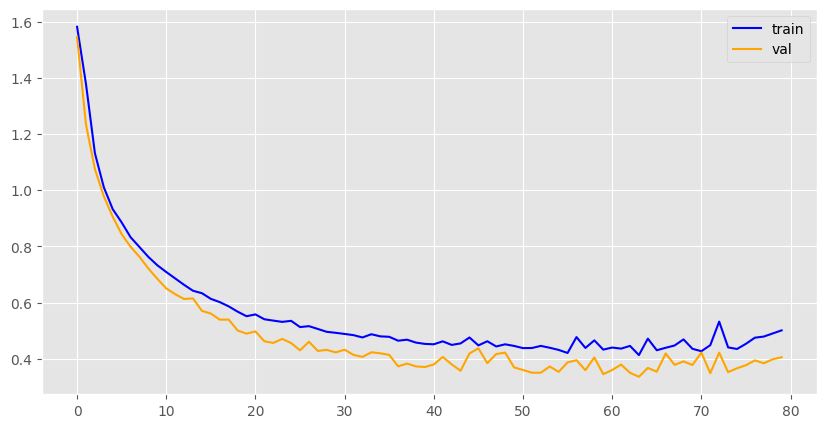

In [568]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(np.arange(n), lstm_history.history.get('loss'), color='blue', label='train')
ax.plot(np.arange(n), lstm_history.history.get('val_loss'), color='orange', label='val')

plt.legend()
plt.show()


In [569]:
X_val_diff = np.diff(
    a=X_val,
    axis=1
).reshape(X_val.shape[0], SEQUENCE_LENGTH - 1, -1)

X_org_diff = np.diff(
    a=X,
    axis=1
).reshape(X.shape[0], SEQUENCE_LENGTH - 1, -1)

In [570]:
train_preds = lstm_model.predict(X_train_kp_diff)
val_preds = lstm_model.predict(X_val_diff)
org_preds = lstm_model.predict(X_org_diff)

In [571]:
np.sum(np.argmax(train_preds, axis=1) == np.argmax(Y_aug, axis=1)) / len(Y_aug)

0.9111574840095819

In [572]:
np.sum(np.argmax(val_preds, axis=1) == np.argmax(Y_val, axis=1)) / len(Y_val)

0.7083333333333334

In [573]:
np.sum(np.argmax(org_preds, axis=1) == Y) / len(Y)

0.9016736401673641

In [638]:
np.where(np.argmax(org_preds, axis=1) != Y)[0]

array([  0,  77, 160, 174, 183, 218, 228, 241, 246, 268, 270, 281, 285,
       291, 299, 300, 304, 319, 327, 332, 373, 418, 466], dtype=int64)

In [639]:
video_names = np.array([name for name, _, _ in res])
video_names[np.where(np.argmax(org_preds, axis=1) != Y)[0]]

array(['please_video_1.mp4', 'what_video_37.mp4', 'love_video_38.mp4',
       'thank_you_video_8.mp4', 'thank_you_video_19.mp4',
       '2023_10_24_21_16_49__SLR.webm', '2023_10_29_16_02_44__SLR.mp4',
       '2023_10_29_16_06_03__SLR.mp4', '2023_10_29_16_06_56__SLR.mp4',
       '2023_10_30_11_35_32__SLR.webm', '2023_10_30_11_36_26__SLR.webm',
       '2023_10_30_11_43_07__SLR.webm', '2023_10_30_11_46_40__SLR.webm',
       '2023_10_30_11_48_29__SLR.webm', '2023_11_05_15_11_03__SLR.webm',
       '2023_11_05_15_11_20__SLR.webm', '2023_11_05_15_12_34__SLR.webm',
       '2023_11_07_19_55_03__SLR.webm', '2023_11_07_19_57_21__SLR.webm',
       '2023_11_07_19_59_50__SLR.webm', '2023_11_07_20_19_52__SLR.webm',
       '2023_11_07_21_28_31__SLR.webm', '2023_11_12_13_48_37__SLR.webm'],
      dtype='<U73')

In [629]:
np.sum(np.argmax(val_preds, axis=1) == np.argmax(Y_val, axis=1)) / len(Y_val)

0.8085106382978723

In [570]:
from sklearn.metrics import ConfusionMatrixDisplay

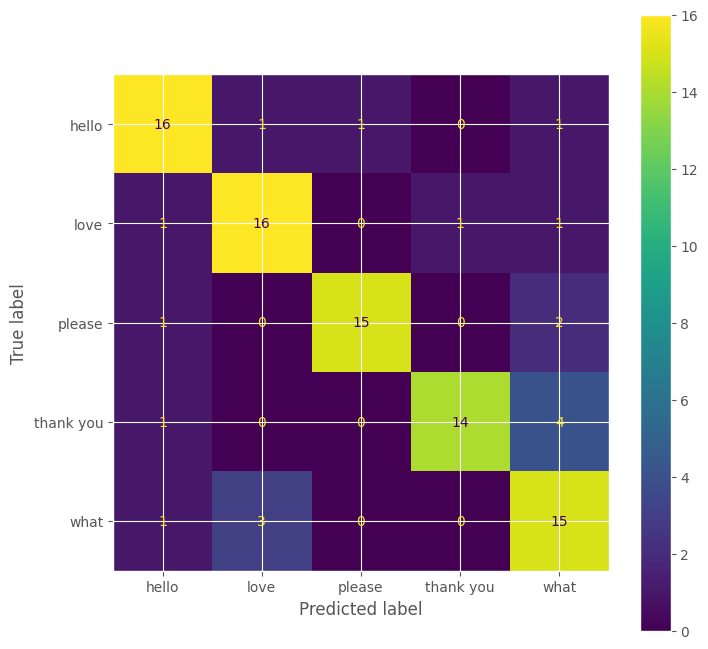

In [635]:
fig, ax = plt.subplots(figsize=(8, 8))

ConfusionMatrixDisplay.from_predictions(
    y_true=np.argmax(Y_val, axis=1),
    y_pred=np.argmax(val_preds, axis=1),
    display_labels=mapping_classes.keys(),
    ax=ax
)

plt.show()


In [636]:
lstm_model.save(os.path.join("..", "models", "LSTM_ROTATION_AUG_81.ckpt"))

INFO:tensorflow:Assets written to: ..\models\LSTM_ROTATION_AUG_81.ckpt\assets


In [72]:
model = tf.keras.models.load_model(
    os.path.join("..", "models", "lstm_new.ckpt")
)

In [78]:
X_train[0].shape

TensorShape([24, 56])

In [76]:
model(tf.expand_dims(X_train[0], 0))[0].numpy()

array([0.19890599, 0.52578115, 0.0519357 , 0.01763343, 0.20574372],
      dtype=float32)